# ✔	 - Import modules -

In [1]:
import os
import time
import numpy as np
import random
from matplotlib import pyplot as plt
from math import exp, cos
import json
from tqdm import tqdm

# ✔	 - Function definition -

# ✘ Corrected Input function

In [2]:
# Function returning the corrected Input
def Ic(Input=0):
    if Input <= 0:
        return 0
    else:
        return (Input)

# ✘ Activity at time t-Delta (delay) function

In [3]:
# function to get the index "-delay/dt" in the list representing m(t-Delta)
def mdelta(synapse_value, delay, t, dt,i):
    if t < delay:  # if the delay is the time is too small, we take m(t-delta)=0
        return 0
    else:  # if the time is above or equal to the delay, we can find the m(t-delta)
        return synapse_value[int(-delay / dt)][i]

# ✘ Plotting functions (Inputs & activities) and save data function

In [4]:
def plottingI(k):
    valueGpe=[0]*n_period
    valueFsi=[0]*n_period
    valueMsn=[0]*n_period
    for stc in structures:
        for t in range(0,n_period):
        
            valueGpe[t]=I['Gpe'][t][k]
            valueFsi[t]=I['Fsi'][t][k]
            valueMsn[t]=I['Msn'][t][k]
        
    fig = plt.figure(figsize=(9,5))
    ax=fig.add_subplot(111)
    ax.plot(time_value, valueGpe, label='Msn')
    ax.plot(time_value, valueFsi, label='Gpe')
    ax.plot(time_value, valueMsn, label='Fsi')
    ax.set_title('Input over time: Neuron {}'.format(k+1))
    ax.set_ylabel('Input')
    ax.set_xlabel('time')
    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [5]:
def plottingA(k):    # better define that function? with choice name etc
    valueGpeMsn=[0]*n_period
    valueFsiGpe=[0]*n_period
    valueMsnFsi=[0]*n_period
    for con in connections:
        for t in range(0,n_period):
        
            valueGpeMsn[t]=m['GpeMsn'][t][k]
            valueFsiGpe[t]=m['FsiGpe'][t][k]
            valueMsnFsi[t]=m['MsnFsi'][t][k]
        
    fig = plt.figure(figsize=(9,5))
    ax=fig.add_subplot(111)
    ax.plot(time_value, valueGpeMsn, label='Msn')
    ax.plot(time_value, valueFsiGpe, label='Gpe')
    ax.plot(time_value, valueMsnFsi, label='Fsi')
    ax.set_title('Activities over time: Neuron {}'.format(k+1))
    ax.set_ylabel('Activity')
    ax.set_xlabel('time')
    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) 

In [6]:
def data_dir(dir="os.getcwd()"):   # will create the files needed to store values in CWD/Data
    directory = os.path.dirname(dir)
    if not os.path.exists('{}/{}'.format(os.getcwd(),'Data')):
        os.makedirs('{}/{}'.format(os.getcwd(),'Data'))
    if not os.path.exists('Data/{}'.format(timestr)):
        os.makedirs('Data/{}'.format(timestr))

# ✔	 - Initial parameters - 

In [7]:
## Population size (number of neuron)
n = 1

## Default Time beginning (second)
t = 0

## Default trial duration (second)
duration = 1.00   

## Default Time resolution (second)
dt = 0.0001  # 0.0001

## Period occuring 
n_period = int(duration // dt) + 1

## Initialization of the random generator (reproductibility)
np.random.seed(0)

In [8]:
time_value = np.arange(0, duration, dt) # creat the timescale, depending on the duration and step dt, for plotting

In [9]:
connections = ["GpeMsn", "FsiGpe", "MsnFsi"] #"MsnMsn", "FsiFsi", "GpeGpe"]
structures = ["Msn", "Fsi", "Gpe"]

In [10]:
 ## Fixed point activity: IN VIVO Values needed
M = {                     
    "Msn": 2,   # spikes/s
    "Fsi": 3,   # spikes/s
    "Gpe": 10   # spikes/s
}

 ## Weights (connextions pre->post ; notation: PostPre)
G = {
    "GpeMsn": 1.00,
    "FsiGpe": 1.00,
    "MsnFsi": 1.00,
    #"MsnMsn": 1.00,
    #"FsiFsi": 1.00,
    #"GpeGpe": 1.00
}

 ## Tau:
tau = {
    "GpeMsn": 0.0200,
    "FsiGpe": 0.0100,
    "MsnFsi": 0.0100,
    # "MsnMsn": 1.00,
    #"FsiFsi": 1.00,
   # "GpeGpe": 1.00
}

 ## Delays:
D = {
    "GpeMsn": 0.0070, # 7ms: Jaeger & Kita, 2011 ; (in vivo-rat & monkey)
    "FsiGpe": 0.0010, # 1ms: Jaeger & Kita, 2011 ; (in vivo-rat & monkey)
    "MsnFsi": 0.0008, # 0.8ms: Gittis et al., 2010 ; (in vitro - mice)
    #"MsnMsn": 1.00,
    #"FsiFsi": 1.00,
   # "GpeGpe": 1.00  # 1ms: Jaeger & Kita, 2011 ; (in vivo-rat & monkey)
}


 ## Noise level (sigma)
N = {
    "Msn": 0.00,   
    "Fsi": 0.00,   
    "Gpe": 0.00
}

In [11]:
input_mapping = {
    "Msn": "MsnFsi",
    "Gpe": "GpeMsn",
    "Fsi": "FsiGpe"
}

activities_mapping = {
    "GpeMsn": "Msn",
    "FsiGpe": "Gpe",
    "MsnFsi": "Fsi"
}

In [12]:
## creation of array of n neurons to store m, dm and connectivity probability(0 or 1)
m, dm, J, H, y = dict(), dict(), dict(), dict(), dict()

for con in connections:   # create an array of 'nperiod' array(to store the value trought the time) with n zeroes

    m[con] = np.zeros((n_period, n))
   
    y[con]=int(D[con]/dt)

    stc = activities_mapping[con]
    m[con][0:(y[con])]= M[stc]
    
    dm[con] = np.zeros((n_period, n))
    
    if con  == 'GpeMsn':         # create an array composed of 0 & 1 depending on the probability "Co"(max=1=100%)
        Co=1.000
    elif con == 'FsiGpe':
        Co=1.000
    elif con == 'MsnFsi':
        Co=1.000
        
    J[con] = np.random.choice(2, size=(n, n), p=[(1-Co),Co])

In [13]:
for stc in structures: 
    if stc  == 'Gpe':         
        H[stc]= M[stc]+G['GpeMsn']*M['Msn']
    elif stc == 'Fsi':
        H[stc]= M[stc]+G['FsiGpe']*M['Gpe']
    elif stc == 'Msn':
        H[stc]= M[stc]+G['MsnFsi']*M['Fsi']


print(' HGpe:',H['Gpe'], 'spk/s','\n','HFsi:',H['Fsi'], 'spk/s','\n','HMsn:',H['Msn'], 'spk/s')

 HGpe: 12.0 spk/s 
 HFsi: 13.0 spk/s 
 HMsn: 5.0 spk/s


In [14]:
## inputs: pick noise value before iteration for calculation optimisation (sigma is different for structures)
I = dict()
for stc in structures: # create an array of 'nperiod' line & n column(to store value trought the time) with noise
    if stc  == 'Gpe':         # create an array composed of 0 & 1 depending on the probability "Co"(max=1=100%)
        sigma = 1.000 # sigma is the standard deviation of the white gausian noise. Here , different for all populat
    elif stc == 'Fsi':
        sigma = 1.000 
    elif stc == 'Msn':
        sigma = 1.000 
    
    #I[stc] = np.random.normal(0, sigma, size=(n_period, n)) + H[stc] # add H, external Inputs calculated above
    I[stc] = np.zeros((n_period,n)) + H[stc]  # same as above but WITHOUT NOISE

# ✔	 - Simulation Core -

In [15]:
for t in tqdm(range(1, n_period)):    ## Update of Inputs
    
    for stc in structures:
        for i in range(n):
            if stc == "Msn" or "Gpe" or "Fsi":
                con = input_mapping[stc] #multiplication by the probability of connexion below with n
                I[stc][t][i] += - np.sum(G[con]* mdelta(m[con][:t + 1], D[con], time_value[t], dt,i) *J[con][i]) /n
            else: 
                continue

    for con in connections:          ## Update of activities : METTRE  NIVEAU BASAL : FREQUENCE UP
        
        for i in range(n):
            stc = activities_mapping[con]
            dm[con][t][i] = dt * (- m[con][t][i] + Ic(I[stc][t][i])) / tau[con]
            
        if t < n_period-1: # we can't add last value of dm to the last value of m
            m[con][t+1]=m[con][t]+dm[con][t]
        else:
            continue

100%|██████████| 9999/9999 [00:00<00:00, 25606.58it/s]


# ✔	 - Result Plots & Save data -

In [16]:
timestr = time.strftime("%Y-%m-%d-%H:%M:%S") # give the date and time that will be used to tag simulation results
data_dir()  # creating the 'Data' directory on CWD and the directory (with date & time) to store the results

for stc in structures:  # save the Input array (npy format) for each neuron population in "structures"
    np.save('Data/{}/{}_Inputs'.format(timestr, stc), I[stc])
    
for con in connections: # save the Activity array (npy format) for each neuron population in "connections"
    np.save('Data/{}/{}_Activities'.format(timestr, con), m[con])

datax={'Weight':G,'Delay':D,'tau':tau,'Noise':N,  # make one dict with all parameters used 
       'Neuron_number':n,'time_trial':t,'duration':duration,'step':dt}

with open('Data/{}/0_Parameters.json'.format(timestr),'w') as f: # save the parameters used during the simulation
            json.dump(datax, f) 

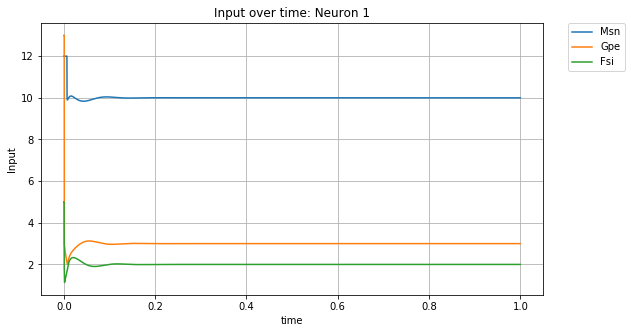

In [17]:
## Plotting INPUTS
for k in range(0,n):
    plottingI(k)
    plt.savefig('Data/{}/In{}.png'.format(timestr,k+1),dpi=300,bbox_inches='tight')
    plt.show()

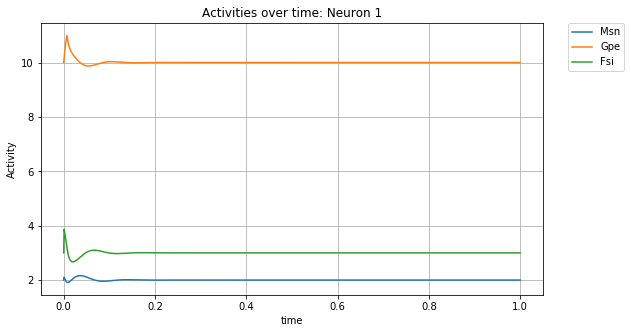

In [18]:
## Plotting ACTIVITIES
for k in range(0,n):
    plottingA(k)
    plt.savefig('Data/{}/Mn{}.png'.format(timestr,k+1),dpi=300,bbox_inches='tight')
    plt.show()

# ✔	 - Mean firing rate plotting - 

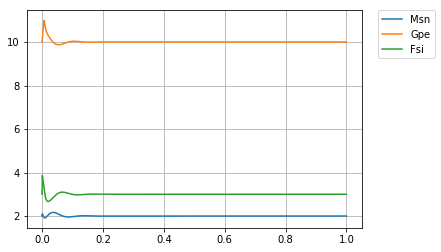

In [19]:
MeaniGM=list()
MeaniMF=list()
MeaniFG=list()
for con in connections:
    for t in range(0,n_period):
        if con  == 'GpeMsn':
            MeaniGM.append(np.mean(m['GpeMsn'][t]))
        elif con == 'MsnFsi':
            MeaniMF.append(np.mean(m['MsnFsi'][t]))
        elif con == 'FsiGpe':
            MeaniFG.append(np.mean(m['FsiGpe'][t]))  

plt.plot(time_value,MeaniGM,label='Msn')
plt.plot(time_value,MeaniFG,label='Gpe')
plt.plot(time_value,MeaniMF,label='Fsi')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()